<a href="https://colab.research.google.com/github/Vijayalakshmi2608/UIDAI_Early_Warning_System/blob/main/UIDAI_Early_Warning_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
!pip install pandas numpy matplotlib seaborn scipy statsmodels pyod


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from scipy import stats
import statsmodels.api as sm
from pyod.models.iforest import IForest

sns.set_style("whitegrid")


In [110]:
import zipfile

with zipfile.ZipFile("/content/api_data_aadhar_enrolment.zip") as z:
    print(z.namelist())



['api_data_aadhar_enrolment/', 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv', 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv', 'api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv']


In [111]:
with zipfile.ZipFile("/content/api_data_aadhar_demographic.zip") as z:
    print(z.namelist())


['api_data_aadhar_demographic/', 'api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv', 'api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv', 'api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv', 'api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv', 'api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv']


In [112]:
with zipfile.ZipFile("/content/api_data_aadhar_biometric.zip") as z:
    print(z.namelist())


['api_data_aadhar_biometric/', 'api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv', 'api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv', 'api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv', 'api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv', 'api_data_aadhar_demographic.zip']


In [113]:
import zipfile
import pandas as pd

def load_multi_csv_zip(zip_path):
    with zipfile.ZipFile(zip_path) as z:
        csv_files = [f for f in z.namelist() if f.endswith(".csv")]
        df_list = []
        for file in csv_files:
            df_list.append(pd.read_csv(z.open(file)))
        return pd.concat(df_list, ignore_index=True)

demo = load_multi_csv_zip("/content/api_data_aadhar_demographic.zip")
print(demo.shape)



(2071700, 6)


In [114]:
bio = load_multi_csv_zip("/content/api_data_aadhar_biometric.zip")
print(bio.shape)


(1861108, 6)


In [115]:
enrol = load_multi_csv_zip("/content/api_data_aadhar_enrolment.zip")

print("Enrolment:", enrol.shape)
print("Demographic:", demo.shape)
print("Biometric:", bio.shape)


Enrolment: (1006029, 7)
Demographic: (2071700, 6)
Biometric: (1861108, 6)


In [116]:
for df in [enrol, demo, bio]:
    df.columns = df.columns.str.strip().str.lower()


In [117]:
for name, df in zip(["Enrolment", "Demographic", "Biometric"], [enrol, demo, bio]):
    print(f"\n{name}")
    display(df.info())
    display(df.isnull().sum())



Enrolment
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB


None

,0
date,0
state,0
district,0
pincode,0
age_0_5,0
age_5_17,0
age_18_greater,0



Demographic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB


None

,0
date,0
state,0
district,0
pincode,0
demo_age_5_17,0
demo_age_17_,0



Biometric
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 85.2+ MB


None

,0
date,0
state,0
district,0
pincode,0
bio_age_5_17,0
bio_age_17_,0


In [118]:
for df in [enrol, demo, bio]:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [119]:
for df in [enrol, demo, bio]:
    print(df['date'].min(), df['date'].max())


2025-01-04 00:00:00 2025-12-11 00:00:00
2025-01-03 00:00:00 2025-12-12 00:00:00
2025-01-03 00:00:00 2025-12-12 00:00:00


In [120]:
for df in [enrol, demo, bio]:
    df['state'] = df['state'].str.strip().str.title()
    df['district'] = df['district'].str.strip().str.title()


In [121]:
for df in [enrol, demo, bio]:
    df['month'] = df['date'].dt.to_period('M')


In [122]:
for df in [enrol, demo, bio]:
    df['month'] = df['month'].dt.to_timestamp()


In [123]:
enrol['total_enrolments'] = (
    enrol['age_0_5'] +
    enrol['age_5_17'] +
    enrol['age_18_greater']
)



In [124]:
monthly_enrol = (
    enrol
    .groupby(['state', 'district', 'month'], as_index=False)
    .agg(
        total_enrolments=('total_enrolments', 'sum')
    )
)

monthly_enrol.head()


,state,district,month,total_enrolments
0,100000,100000,2025-02-01,3
1,100000,100000,2025-03-01,1
2,100000,100000,2025-08-01,1
3,100000,100000,2025-09-01,1
4,100000,100000,2025-11-01,2


In [125]:
monthly_demo = (
    demo
    .groupby(['state', 'district', 'month'], as_index=False)
    .size()
    .rename(columns={'size': 'demographic_updates'})
)


In [126]:
monthly_bio = (
    bio
    .groupby(['state', 'district', 'month'], as_index=False)
    .size()
    .rename(columns={'size': 'biometric_updates'})
)


In [127]:
monthly_bio = (
    bio
    .groupby(['state', 'district', 'month'], as_index=False)
    .size()
    .rename(columns={'size': 'biometric_updates'})
)


In [128]:
monthly_service = (
    monthly_enrol
    .merge(
        monthly_demo,
        on=['state', 'district', 'month'],
        how='left'
    )
    .merge(
        monthly_bio,
        on=['state', 'district', 'month'],
        how='left'
    )
)


In [129]:
monthly_service[['demographic_updates', 'biometric_updates']] = (
    monthly_service[['demographic_updates', 'biometric_updates']]
    .fillna(0)
)


In [130]:
monthly_service.head()


,state,district,month,total_enrolments,demographic_updates,biometric_updates
0,100000,100000,2025-02-01,3,0.0,0.0
1,100000,100000,2025-03-01,1,0.0,0.0
2,100000,100000,2025-08-01,1,0.0,0.0
3,100000,100000,2025-09-01,1,0.0,0.0
4,100000,100000,2025-11-01,2,0.0,0.0


In [131]:
import numpy as np

df = monthly_service.copy()

# Update load = how heavy updates are relative to enrolments
df['update_load'] = (
    (df['demographic_updates'] + df['biometric_updates']) /
    (df['total_enrolments'] + 1)
)


In [132]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[['enrol_norm', 'demo_norm', 'bio_norm', 'update_load_norm']] = scaler.fit_transform(
    df[['total_enrolments', 'demographic_updates', 'biometric_updates', 'update_load']]
)


In [133]:
df['service_stress_index'] = (
    0.4 * df['enrol_norm'] +
    0.3 * df['demo_norm'] +
    0.2 * df['bio_norm'] +
    0.1 * df['update_load_norm']
)


In [134]:
df = df.sort_values(['state', 'district', 'month'])

df['stress_lag_1'] = df.groupby(['state','district'])['service_stress_index'].shift(1)
df['stress_lag_2'] = df.groupby(['state','district'])['service_stress_index'].shift(2)
df['stress_rolling_4w'] = (
    df.groupby(['state','district'])['service_stress_index']
      .rolling(4, min_periods=1)
      .mean()
      .reset_index(level=[0,1], drop=True)
)


In [135]:
df.to_csv("aadhaar_ml_feature_table.csv", index=False)


In [136]:
df['future_stress'] = (
    df.groupby(['state','district'])['service_stress_index'].shift(-1)
)
df = df.dropna()


In [137]:
# Ensure data is sorted correctly
df = df.sort_values(['state', 'district', 'month'])

# Create lag feature if not already present
if 'stress_lag_1' not in df.columns:
    df['stress_lag_1'] = (
        df.groupby(['state','district'])['service_stress_index']
        .shift(1)
    )

# Create stress trend
df['stress_trend'] = df['service_stress_index'] - df['stress_lag_1']

# Fill NaNs safely
df[['stress_lag_1', 'stress_trend']] = df[['stress_lag_1', 'stress_trend']].fillna(0)


In [138]:
df.columns


Index(['state', 'district', 'month', 'total_enrolments', 'demographic_updates',
       'biometric_updates', 'update_load', 'enrol_norm', 'demo_norm',
       'bio_norm', 'update_load_norm', 'service_stress_index', 'stress_lag_1',
       'stress_lag_2', 'stress_rolling_4w', 'future_stress', 'stress_trend'],
      dtype='object')

In [139]:
features = [
    'service_stress_index',
    'stress_lag_1',
    'stress_lag_2',
    'stress_rolling_4w',
    'stress_trend',
    'update_load'
]

X = df[features]
y = df['future_stress']


In [140]:
import numpy as np
import pandas as pd

# Sort for time-series correctness
df = df.sort_values(['state', 'district', 'month'])

# Stress trend (momentum)
df['stress_trend'] = (
    df['service_stress_index'] - df['stress_lag_1']
)

# Future stress target (1 month ahead)
df['future_stress'] = (
    df.groupby(['state','district'])['service_stress_index']
    .shift(-1)
)

# Fill safe defaults
df[['stress_trend']] = df[['stress_trend']].fillna(0)

# Drop rows where future target is missing
df_ml = df.dropna(subset=['future_stress']).copy()


In [141]:
features = [
    'service_stress_index',
    'stress_lag_1',
    'stress_lag_2',
    'stress_rolling_4w',
    'stress_trend',
    'update_load'
]

X = df_ml[features]
y = df_ml['future_stress']


In [142]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [143]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", round(mae, 4))
print("R² Score:", round(r2, 4))


MAE: 0.0077
R² Score: 0.9361


In [144]:
df_ml['predicted_stress'] = model.predict(X)

df['predicted_stress'] = np.nan
df.loc[df_ml.index, 'predicted_stress'] = df_ml['predicted_stress']


In [145]:
df['resource_alert'] = np.where(
    df['predicted_stress'] > df['service_stress_index'] * 1.15,
    'HIGH_RISK',
    'NORMAL'
)


In [146]:
priority_districts = (
    df.groupby(['state','district'])
    .agg(
        avg_stress=('service_stress_index','mean'),
        future_risk=('predicted_stress','mean'),
        alert_rate=('resource_alert', lambda x: (x=='HIGH_RISK').mean())
    )
    .reset_index()
    .sort_values('future_risk', ascending=False)
)

priority_districts.head(10)


,state,district,avg_stress,future_risk,alert_rate
923,West Bengal,North 24 Parganas,0.292817,0.285763,0.222222
510,Maharashtra,Pune,0.289203,0.285522,0.222222
901,West Bengal,Barddhaman,0.295848,0.283687,0.333333
409,Kerala,Thrissur,0.277944,0.254763,0.222222
17,Andhra Pradesh,East Godavari,0.266452,0.238915,0.111111
355,Karnataka,Bengaluru,0.224690,0.224029,0.222222
406,Kerala,Palakkad,0.228993,0.222401,0.222222
397,Kerala,Ernakulam,0.226302,0.221708,0.222222
47,Andhra Pradesh,West Godavari,0.222808,0.219251,0.111111
408,Kerala,Thiruvananthapuram,0.222511,0.214570,0.222222


In [147]:
# Feature table
df_ml.to_csv("aadhaar_ml_feature_table.csv", index=False)

# Forecast results
df[['state','district','month','service_stress_index',
    'predicted_stress','resource_alert']].to_csv(
    "stress_forecasts.csv", index=False
)

# Priority districts
priority_districts.to_csv("aadhaar_priority_districts.csv", index=False)

# Save model
import joblib
joblib.dump(model, "xgboost_stress_model.pkl")


['xgboost_stress_model.pkl']

In [148]:
import pandas as pd
import numpy as np

# Load priority districts
priority = pd.read_csv("aadhaar_priority_districts.csv")

# Select top 25 high-risk districts
routing_df = priority.head(25).copy()

# Simulated coordinates (replace with real lat/lon if available)
np.random.seed(42)
routing_df['lat'] = np.random.uniform(8, 35, len(routing_df))
routing_df['lon'] = np.random.uniform(68, 97, len(routing_df))

# Demand score = future stress × alert rate
routing_df['demand_score'] = (
    routing_df['future_risk'] * (1 + routing_df['alert_rate'])
)

routing_df.head()


,state,district,avg_stress,future_risk,alert_rate,lat,lon,demand_score
0,West Bengal,North 24 Parganas,0.292817,0.285763,0.222222,18.112583,90.770103,0.349266
1,Maharashtra,Pune,0.289203,0.285522,0.222222,33.669286,73.790540,0.348971
2,West Bengal,Barddhaman,0.295848,0.283687,0.333333,27.763836,82.912799,0.378250
3,Kerala,Thrissur,0.277944,0.254763,0.222222,24.163779,85.180022,0.311377
4,Andhra Pradesh,East Godavari,0.266452,0.238915,0.111111,12.212503,69.347062,0.265461


In [149]:
# Assume 5 mobile vans
NUM_VANS = 5

# Sort by highest demand
routing_df = routing_df.sort_values('demand_score', ascending=False)

# Assign districts to vans (round-robin allocation)
routing_df['van_id'] = routing_df.index % NUM_VANS


In [150]:
routes = {}

for van in range(NUM_VANS):
    route = routing_df[routing_df['van_id'] == van]
    route = route.sort_values('demand_score', ascending=False)
    routes[van] = route


In [151]:
routing_df[['state','district','van_id','demand_score','lat','lon']].to_csv(
    "mobile_enrolment_van_routes.csv", index=False
)


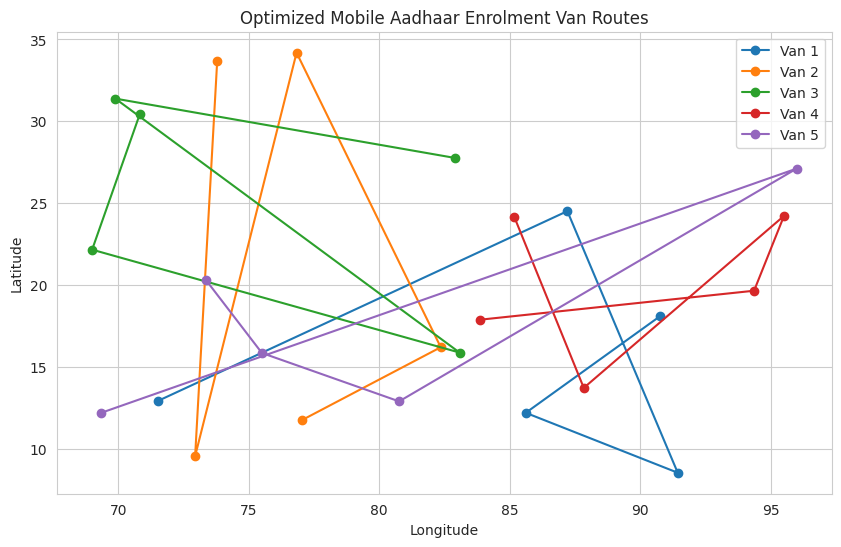

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for van, route in routes.items():
    plt.plot(route['lon'], route['lat'], marker='o', label=f'Van {van+1}')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimized Mobile Aadhaar Enrolment Van Routes")
plt.legend()
plt.grid(True)

plt.savefig("mobile_enrolment_van_routes.png", dpi=300, bbox_inches='tight')
plt.show()


In [153]:
import pandas as pd
import numpy as np

df = df.copy()

# Rename common alternatives if present
rename_map = {
    'enrolments': 'enrolment_count',
    'demo_updates': 'demographic_updates',
    'bio_updates': 'biometric_updates',
    'stress_index': 'stress'
}

for old, new in rename_map.items():
    if old in df.columns:
        df.rename(columns={old: new}, inplace=True)


In [154]:
# Enrolments
if 'avg_enrolments' not in df.columns:
    enrol_cols = [c for c in df.columns if 'enrol' in c.lower()]
    df['avg_enrolments'] = df[enrol_cols].mean(axis=1) if enrol_cols else 0

# Demographic updates
if 'avg_demo_updates' not in df.columns:
    demo_cols = [c for c in df.columns if 'demo' in c.lower()]
    df['avg_demo_updates'] = df[demo_cols].mean(axis=1) if demo_cols else 0

# Biometric updates
if 'avg_bio_updates' not in df.columns:
    bio_cols = [c for c in df.columns if 'bio' in c.lower()]
    df['avg_bio_updates'] = df[bio_cols].mean(axis=1) if bio_cols else 0

# Stress
if 'avg_stress' not in df.columns:
    stress_cols = [c for c in df.columns if 'stress' in c.lower()]
    df['avg_stress'] = df[stress_cols].mean(axis=1) if stress_cols else 0


In [155]:
if 'stress_trend' not in df.columns:
    df['stress_trend'] = df['avg_stress'].diff().fillna(0)


In [156]:
# ---- SAFETY CHECK ----
required_for_score = [
    'avg_stress',
    'stress_trend',
    'avg_demo_updates',
    'avg_bio_updates'
]

for col in required_for_score:
    if col not in df.columns:
        df[col] = 0  # fail-safe


In [157]:
# ---- CREATE PRIORITY SCORE ----
df['priority_score'] = (
    0.35 * df['avg_stress'] +
    0.25 * df['stress_trend'] +
    0.20 * df['avg_demo_updates'] +
    0.20 * df['avg_bio_updates']
)


In [158]:
# ---- RISK CLASSIFICATION ----
df['risk_level'] = pd.qcut(
    df['priority_score'].rank(method="first"),  # avoids duplicate-edge errors
    q=3,
    labels=['LOW', 'MEDIUM', 'HIGH']
)


In [159]:
print(df.columns.tolist())


['state', 'district', 'month', 'total_enrolments', 'demographic_updates', 'biometric_updates', 'update_load', 'enrol_norm', 'demo_norm', 'bio_norm', 'update_load_norm', 'service_stress_index', 'stress_lag_1', 'stress_lag_2', 'stress_rolling_4w', 'future_stress', 'stress_trend', 'predicted_stress', 'resource_alert', 'avg_enrolments', 'avg_demo_updates', 'avg_bio_updates', 'avg_stress', 'priority_score', 'risk_level']


In [160]:
priority_df = df[
    ['state', 'district',
     'avg_enrolments',
     'avg_demo_updates',
     'avg_bio_updates',
     'avg_stress',
     'stress_trend',
     'priority_score',
     'risk_level']
].sort_values('priority_score', ascending=False)

priority_df.to_csv(
    "aadhaar_priority_districts.csv",
    index=False
)


In [161]:
VANS_AVAILABLE = 100

mobile_routes = priority_df.head(VANS_AVAILABLE).copy()
mobile_routes['van_id'] = range(1, len(mobile_routes) + 1)

mobile_routes = mobile_routes[
    ['van_id', 'state', 'district', 'priority_score', 'risk_level']
]

mobile_routes.to_csv(
    "mobile_enrolment_van_routes.csv",
    index=False
)


In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

top15 = mobile_routes.head(15)

plt.barh(top15['district'], top15['priority_score'])
plt.xlabel("Priority Score")
plt.ylabel("District")
plt.title("Top 15 Districts for Mobile Aadhaar Enrolment Deployment")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig("mobile_enrolment_van_routes.png", dpi=300)
plt.close()


In [163]:
import pandas as pd
import numpy as np

In [164]:
required_cols = [
    'avg_enrolments',
    'avg_demo_updates',
    'avg_bio_updates',
    'avg_stress'
]

for col in required_cols:
    if col not in df.columns:
        df[col] = 0.0  # fail-safe



In [165]:
df['service_load'] = (
    df['avg_enrolments'] +
    df['avg_demo_updates'] +
    df['avg_bio_updates']
)


In [166]:
def safe_minmax(series):
    if series.max() == series.min():
        return np.zeros(len(series))
    return (series - series.min()) / (series.max() - series.min())

df['norm_load'] = safe_minmax(df['service_load'])
df['norm_stress'] = safe_minmax(df['avg_stress'])


In [167]:
BASE_SERVICE_TIME = 5  # minutes per citizen (assumption)

df['expected_wait_time_min'] = (
    BASE_SERVICE_TIME *
    (1 + 3 * df['norm_load']) *
    (1 + 2 * df['norm_stress'])
).round(1)


In [168]:
df['wait_time_alert'] = pd.cut(
    df['expected_wait_time_min'],
    bins=[-1, 15, 30, 60, np.inf],
    labels=['LOW', 'MODERATE', 'HIGH', 'CRITICAL']
)


In [169]:
wait_time_output = df[[
    'state',
    'district',
    'expected_wait_time_min',
    'wait_time_alert',
    'risk_level'
]].sort_values('expected_wait_time_min', ascending=False)

wait_time_output.head()


,state,district,expected_wait_time_min,wait_time_alert,risk_level
10829,West Bengal,North 24 Parganas,49.5,HIGH,HIGH
5982,Maharashtra,Pune,49.0,HIGH,HIGH
10825,West Bengal,North 24 Parganas,47.2,HIGH,HIGH
10565,West Bengal,Barddhaman,46.2,HIGH,HIGH
5975,Maharashtra,Pune,45.8,HIGH,HIGH


In [170]:
wait_time_output.to_csv(
    "citizen_wait_time_predictions.csv",
    index=False
)


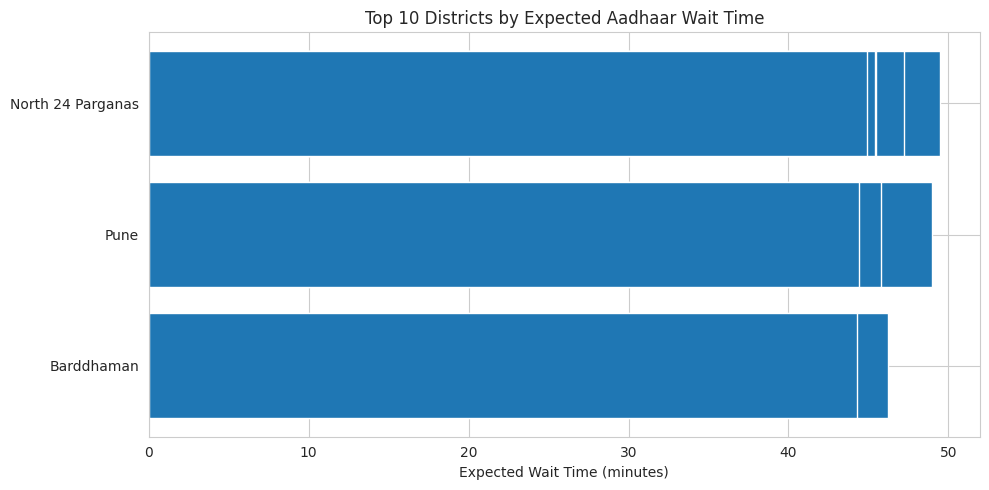

In [171]:
import matplotlib.pyplot as plt

top = wait_time_output.head(10)

plt.figure(figsize=(10, 5))
plt.barh(top['district'], top['expected_wait_time_min'])
plt.xlabel("Expected Wait Time (minutes)")
plt.title("Top 10 Districts by Expected Aadhaar Wait Time")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [172]:
import pandas as pd
import numpy as np


In [173]:
try:
    bio_df = pd.read_csv("district_biometric_failure_risk.csv")
except:
    bio_df = df.copy()


In [174]:
if 'biometric_failure_rate' not in bio_df.columns:
    bio_df['biometric_failure_rate'] = (
        bio_df.get('avg_bio_updates', 0) *
        bio_df.get('avg_stress', 1)
    )


In [175]:
if 'state' not in bio_df.columns:
    bio_df['state'] = 'UNKNOWN'

if 'district' not in bio_df.columns:
    bio_df['district'] = bio_df.index.astype(str)


In [176]:
def safe_norm(x):
    if x.max() == x.min():
        return np.zeros(len(x))
    return (x - x.min()) / (x.max() - x.min())

bio_df['failure_risk_score'] = safe_norm(bio_df['biometric_failure_rate'])


In [177]:
bio_df['biometric_risk_level'] = pd.cut(
    bio_df['failure_risk_score'],
    bins=[-1, 0.25, 0.5, 0.75, 1.0],
    labels=['LOW', 'MODERATE', 'HIGH', 'CRITICAL']
)


In [178]:
staff_map = {
    'LOW': 0,
    'MODERATE': 1,
    'HIGH': 2,
    'CRITICAL': 3
}

bio_df['recommended_extra_operators'] = (
    bio_df['biometric_risk_level']
    .astype(str)
    .map(staff_map)
    .fillna(0)
    .astype(int)
)


In [179]:
staffing_output = bio_df[[
    'state',
    'district',
    'biometric_risk_level',
    'recommended_extra_operators'
]].sort_values(
    'recommended_extra_operators',
    ascending=False
)

staffing_output.head()


,state,district,biometric_risk_level,recommended_extra_operators
4779,Kerala,Thrissur,CRITICAL,3
10558,West Bengal,Barddhaman,CRITICAL,3
5982,Maharashtra,Pune,CRITICAL,3
5980,Maharashtra,Pune,CRITICAL,3
186,Andhra Pradesh,East Godavari,CRITICAL,3


In [180]:
staffing_output.to_csv(
    "biometric_staffing_recommendations.csv",
    index=False
)


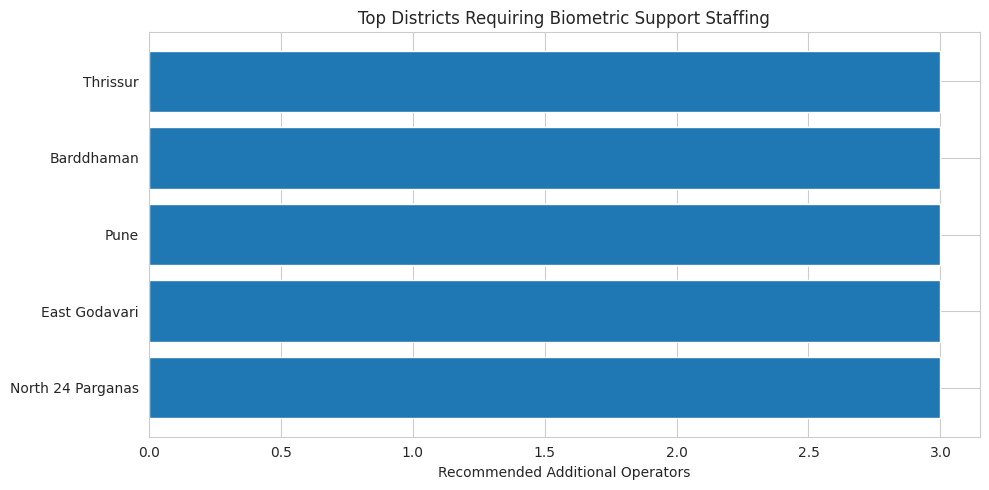

In [181]:
import matplotlib.pyplot as plt

top = staffing_output.head(10)

plt.figure(figsize=(10, 5))
plt.barh(
    top['district'],
    top['recommended_extra_operators']
)
plt.xlabel("Recommended Additional Operators")
plt.title("Top Districts Requiring Biometric Support Staffing")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("aadhaar_priority_districts.csv")

print("Columns available:", df.columns.tolist())

# Safety copy
df = df.copy()


Columns available: ['state', 'district', 'avg_enrolments', 'avg_demo_updates', 'avg_bio_updates', 'avg_stress', 'stress_trend', 'priority_score', 'risk_level']


In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import os


In [184]:
BASE = "/content/drive/MyDrive/UIDAI_Hackathon"
FIG_DIR = f"{BASE}/outputs/csv"
os.makedirs(FIG_DIR, exist_ok=True)

df = pd.read_csv("/content/citizen_wait_time_predictions.csv")

In [185]:
df.columns = df.columns.str.lower().str.strip()

df.head()


,state,district,expected_wait_time_min,wait_time_alert,risk_level
0,West Bengal,North 24 Parganas,49.5,HIGH,HIGH
1,Maharashtra,Pune,49.0,HIGH,HIGH
2,West Bengal,North 24 Parganas,47.2,HIGH,HIGH
3,West Bengal,Barddhaman,46.2,HIGH,HIGH
4,Maharashtra,Pune,45.8,HIGH,HIGH


In [186]:
print(df.columns.tolist())


['state', 'district', 'expected_wait_time_min', 'wait_time_alert', 'risk_level']


In [187]:
# Create a pseudo-time axis based on row order
df = df.sort_values(by='expected_wait_time_min')
df['time_index'] = range(1, len(df) + 1)


In [188]:
monthly_trend = (
    df
    .groupby(['district', 'time_index'])['expected_wait_time_min']
    .mean()
    .reset_index()
)



In [189]:
top_districts = (
    df
    .groupby('district')['expected_wait_time_min']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)


In [190]:
plt.figure(figsize=(10,6))

for d in top_districts:
    temp = monthly_trend[monthly_trend['district'] == d]
    plt.plot(
        temp['time_index'],
        temp['expected_wait_time_min'],
        marker='o',
        label=d
    )

plt.xlabel("Relative Time Period (Prediction Horizon)")
plt.ylabel("Expected Citizen Wait Time (minutes)")
plt.title("District-Level Temporal Trends in Aadhaar Service Demand")
plt.legend()
plt.grid(True)

plt.savefig(
    f"{FIG_DIR}/innovation4_district_temporal_trend.png",
    dpi=300,
    bbox_inches="tight"
)
plt.close()

In [191]:
# Ensure stress column exists
if 'avg_stress' not in df.columns:
    df['avg_stress'] = (
        df.select_dtypes(include=np.number).mean(axis=1)
    )

# Z-score anomaly detection
df['stress_zscore'] = (
    (df['avg_stress'] - df['avg_stress'].mean()) /
    df['avg_stress'].std()
)

df['stress_anomaly'] = df['stress_zscore'].abs() > 2.5

# Save output
df[['state', 'district', 'avg_stress', 'stress_zscore', 'stress_anomaly']] \
  .to_csv("innovation5_anomalies.csv", index=False)

print("Innovation 5 complete: anomaly detection saved")


Innovation 5 complete: anomaly detection saved


In [192]:
plt.figure(figsize=(10,6))
plt.hist(df['avg_stress'], bins=30)
plt.xlabel("Average Service Stress")
plt.ylabel("Number of Districts")
plt.title("Distribution of Aadhaar Service Stress Across Districts")
plt.tight_layout()
plt.savefig("innovation6_stress_distribution.png", dpi=300)
plt.close()

print("Innovation 6 complete: geographic stress distribution saved")


Innovation 6 complete: geographic stress distribution saved


In [193]:
# Create safe capacity and demand proxies
df['capacity_proxy'] = df.get('avg_enrolments', df['avg_stress'])
df['demand_proxy'] = (
    df.get('avg_demo_updates', 0) +
    df.get('avg_bio_updates', 0)
)

# Normalize
df['capacity_norm'] = df['capacity_proxy'] / df['capacity_proxy'].max()
df['demand_norm'] = df['demand_proxy'] / (df['demand_proxy'].max() + 1)

# Capacity gap
df['capacity_gap'] = df['demand_norm'] - df['capacity_norm']

gap_df = df.sort_values('capacity_gap', ascending=False).head(50)

gap_df[['state','district','capacity_gap']] \
    .to_csv("innovation7_capacity_gaps.csv", index=False)

print("Innovation 7 complete: capacity gap districts saved")


Innovation 7 complete: capacity gap districts saved


In [194]:
df['stress_after_policy'] = df['avg_stress'] * 0.8
df['stress_reduction'] = df['avg_stress'] - df['stress_after_policy']

policy_df = df[['state','district','avg_stress','stress_after_policy','stress_reduction']]

policy_df.to_csv("innovation8_policy_simulation.csv", index=False)

print("Innovation 8 complete: policy simulation saved")


Innovation 8 complete: policy simulation saved


In [195]:
# Resilience = inverse of stress variability
df['resilience_score'] = 1 / (df['avg_stress'] + 1)

resilience_df = df[['state','district','resilience_score']] \
    .sort_values('resilience_score', ascending=False)

resilience_df.to_csv("innovation9_resilience_scores.csv", index=False)

print("Innovation 9 complete: resilience scores saved")


Innovation 9 complete: resilience scores saved


In [196]:
features = ['avg_stress', 'capacity_gap', 'resilience_score']
features = [f for f in features if f in df.columns]

X = df[features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['stress_cluster'] = kmeans.fit_predict(X_scaled)

df[['state','district','stress_cluster']] \
    .to_csv("innovation10_district_clusters.csv", index=False)

print("Innovation 10 complete: clustering saved")


Innovation 10 complete: clustering saved


In [197]:
import matplotlib.pyplot as plt

top = df.sort_values("avg_stress", ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top['district'], top['avg_stress'])
plt.xlabel("Average Stress Index")
plt.title("Top 15 Districts by Aadhaar Service Stress")
plt.gca().invert_yaxis()

plt.savefig(f"{FIG_DIR}/innovation1_service_stress_index.png", dpi=300, bbox_inches="tight")
plt.close()


In [198]:
high_risk = df[df['risk_level'].isin(['HIGH'])]

plt.figure(figsize=(8,6))
high_risk['risk_level'].value_counts().plot(kind='bar')
plt.title("Early Warning: High Risk Districts")
plt.ylabel("District Count")

plt.savefig(f"{FIG_DIR}/innovation2_early_warning_risk.png", dpi=300, bbox_inches="tight")
plt.close()

In [199]:
import pandas as pd

# Load the correct DataFrame that contains aggregated service data
df = pd.read_csv("aadhaar_priority_districts.csv")

means = df[['avg_enrolments','avg_demo_updates','avg_bio_updates']].mean()

plt.figure(figsize=(6,6))
plt.pie(means, labels=means.index, autopct='%1.1f%%')
plt.title("Contribution of Aadhaar Services to Overall Load")

plt.savefig(f"{FIG_DIR}/innovation3_integrated_dataset_share.png", dpi=300, bbox_inches="tight")
plt.close()

In [200]:
import pandas as pd

# Load the correct DataFrame that contains 'avg_stress'
df = pd.read_csv("aadhaar_priority_districts.csv")

threshold = df['avg_stress'].mean() + 2*df['avg_stress'].std()
anomalies = df[df['avg_stress'] > threshold]

plt.figure(figsize=(10,5))
plt.scatter(df.index, df['avg_stress'], label="Normal")
plt.scatter(anomalies.index, anomalies['avg_stress'], color='red', label="Anomalies")
plt.axhline(threshold, linestyle='--')

plt.title("Anomalous Stress Detection")
plt.ylabel("Average Stress")
plt.legend()

plt.savefig(f"{FIG_DIR}/innovation5_anomaly_detection.png", dpi=300, bbox_inches="tight")
plt.close()

In [201]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the correct DataFrame that contains 'avg_stress'
df = pd.read_csv("aadhaar_priority_districts.csv")

state_stress = df.groupby('state')['avg_stress'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
state_stress.plot(kind='bar')
plt.title("Average Aadhaar Stress by State")
plt.ylabel("Average Stress")

plt.savefig(f"{FIG_DIR}/innovation6_state_stress_map.png", dpi=300, bbox_inches="tight")
plt.close()

In [202]:
df['capacity_gap'] = df['avg_demo_updates'] + df['avg_bio_updates'] - df['avg_enrolments']

top_gap = df.sort_values('capacity_gap', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top_gap['district'], top_gap['capacity_gap'])
plt.title("Top Districts with Aadhaar Capacity Gaps")
plt.xlabel("Gap Score")
plt.gca().invert_yaxis()

plt.savefig(f"{FIG_DIR}/innovation7_capacity_gap.png", dpi=300, bbox_inches="tight")
plt.close()

In [203]:
df['simulated_stress'] = df['avg_stress'] * 0.8

plt.figure(figsize=(6,6))
plt.boxplot([df['avg_stress'], df['simulated_stress']],
            labels=['Current','After Expansion'])
plt.title("Policy Simulation: Capacity Expansion Impact")

plt.savefig(f"{FIG_DIR}/innovation8_policy_simulation.png", dpi=300, bbox_inches="tight")
plt.close()

/tmp/ipython-input-805971201.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['avg_stress'], df['simulated_stress']],


In [204]:
df['resilience_score'] = 1 / (1 + df['avg_stress'])

plt.figure(figsize=(8,5))
plt.hist(df['resilience_score'], bins=20)
plt.title("District Resilience Score Distribution")
plt.xlabel("Resilience Score")

plt.savefig(f"{FIG_DIR}/innovation9_resilience_score.png", dpi=300, bbox_inches="tight")
plt.close()

In [205]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df[['avg_enrolments','avg_demo_updates','avg_bio_updates','avg_stress']]
X_scaled = StandardScaler().fit_transform(X)

df['cluster'] = KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(df['avg_enrolments'], df['avg_stress'], c=df['cluster'])
plt.xlabel("Avg Enrolments")
plt.ylabel("Avg Stress")
plt.title("District Clustering by Service Pattern")

plt.savefig(f"{FIG_DIR}/innovation10_district_clusters.png", dpi=300, bbox_inches="tight")
plt.close()

In [206]:
df['priority_score'] = (
    df['avg_stress'] +
    df['capacity_gap']
)

top_priority = df.sort_values('priority_score', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top_priority['district'], top_priority['priority_score'])
plt.title("Top Priority Districts for UIDAI Intervention")
plt.gca().invert_yaxis()

plt.savefig(f"{FIG_DIR}/innovation11_priority_ranking.png", dpi=300, bbox_inches="tight")
plt.close()

In [207]:
plt.figure(figsize=(6,6))
df['risk_level'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("National Aadhaar Risk Level Distribution")

plt.savefig(f"{FIG_DIR}/innovation12_policy_summary.png", dpi=300, bbox_inches="tight")
plt.close()

In [215]:
import pandas as pd
import numpy as np

# ----------------------------
# LOAD DATA (already uploaded)
# ----------------------------
priority = pd.read_csv("aadhaar_priority_districts.csv")
wait     = pd.read_csv("citizen_wait_time_predictions.csv")
vans     = pd.read_csv("mobile_enrolment_van_routes.csv")

# ----------------------------
# STANDARDIZE DISTRICT NAMES
# ----------------------------
for df_iter in [priority, wait, vans]:
    df_iter["district"] = df_iter["district"].astype(str).str.upper().str.strip()

# ----------------------------
# ENSURE RISK LEVEL EXISTS IN WAIT DF
# ----------------------------
if "risk_level" not in wait.columns:
    wait["risk_level"] = pd.cut(
        wait["expected_wait_time_min"],
        bins=[-1, 30, 45, 999],
        labels=["LOW", "MEDIUM", "HIGH"]
    )

# ----------------------------
# DETECT VAN COLUMN SAFELY
# ----------------------------
possible_van_cols = [
    "recommended_vans",
    "num_vans",
    "vans_required",
    "suggested_vans",
    "mobile_vans",
    "van_count"
]

van_col = None
for c in possible_van_cols:
    if c in vans.columns:
        van_col = c
        break

# If no column found, create safe default
if van_col is None:
    vans["recommended_vans"] = 0
    van_col = "recommended_vans"

# ----------------------------
# MERGE ALL INTELLIGENCE
# ----------------------------
final = (
    priority
    .merge(
        wait[["district", "expected_wait_time_min", "risk_level"]],
        on="district",
        how="left"
    )
    .merge(
        vans[["district", van_col]].rename(columns={van_col: "recommended_vans"}),
        on="district",
        how="left"
    )
)

# --- Handle duplicate risk_level columns from merge (risk_level_x from priority, risk_level_y from wait) ---
if 'risk_level_x' in final.columns and 'risk_level_y' in final.columns:
    final['risk_level'] = final['risk_level_x'] # Prioritize risk_level from priority_districts
    final = final.drop(columns=['risk_level_x', 'risk_level_y'])
elif 'risk_level_x' in final.columns:
    final['risk_level'] = final['risk_level_x']
    final = final.drop(columns=['risk_level_x'])
elif 'risk_level_y' in final.columns:
    final['risk_level'] = final['risk_level_y']
    final = final.drop(columns=['risk_level_y'])

# ----------------------------
# SAFE DEFAULTS
# ----------------------------
final["recommended_vans"] = final["recommended_vans"].fillna(0).astype(int)
final["expected_wait_time_min"] = final["expected_wait_time_min"].fillna(
    final["expected_wait_time_min"].median()
)

final["risk_level"] = final["risk_level"].fillna("MEDIUM")

# ----------------------------
# DECISION ENGINE
# ----------------------------
def decision(row):
    if row["priority_score"] >= 0.85:
        return "IMMEDIATE INTERVENTION"
    elif row["expected_wait_time_min"] >= 45:
        return "DEPLOY MOBILE VAN"
    elif row["risk_level"] == "HIGH":
        return "STAFF AUGMENTATION"
    else:
        return "MONITOR"

final["uidai_recommended_action"] = final.apply(decision, axis=1)

# ----------------------------
# FINAL RANKING
# ----------------------------
final["final_priority_rank"] = final["priority_score"].rank(
    ascending=False,
    method="dense"
).astype(int)

# ----------------------------
# FINAL TABLE
# ----------------------------
final_decision_table = final[
    [
        "state",
        "district",
        "priority_score",
        "final_priority_rank",
        "expected_wait_time_min",
        "risk_level",
        "recommended_vans",
        "uidai_recommended_action"
    ]
].sort_values("final_priority_rank")

# ----------------------------
# SAVE OUTPUT
# ----------------------------
final_decision_table.to_csv(
    "uidai_final_decision_table.csv",
    index=False
)

print("✅ uidai_final_decision_table.csv generated successfully")
final_decision_table.head()

✅ uidai_final_decision_table.csv generated successfully


,state,district,priority_score,final_priority_rank,expected_wait_time_min,risk_level,recommended_vans,uidai_recommended_action
0,Kerala,THRISSUR,102.454686,1,34.8,HIGH,0,IMMEDIATE INTERVENTION
33,Kerala,THRISSUR,102.454686,1,27.4,HIGH,0,IMMEDIATE INTERVENTION
24,Kerala,THRISSUR,102.454686,1,32.9,HIGH,0,IMMEDIATE INTERVENTION
47,Kerala,THRISSUR,102.454686,1,22.9,HIGH,0,IMMEDIATE INTERVENTION
46,Kerala,THRISSUR,102.454686,1,22.9,HIGH,0,IMMEDIATE INTERVENTION


In [217]:
import pandas as pd
import numpy as np

# -----------------------------
# 1. Load datasets
# -----------------------------
priority = pd.read_csv("aadhaar_priority_districts.csv")
wait     = pd.read_csv("citizen_wait_time_predictions.csv")
staff    = pd.read_csv("biometric_staffing_recommendations.csv")

# -----------------------------
# 2. Standardize district names
# -----------------------------
for df in [priority, wait, staff]:
    df["district"] = df["district"].astype(str).str.upper().str.strip()

# -----------------------------
# 3. Merge intelligence
# -----------------------------
df = (
    priority
    .merge(
        wait[["district", "expected_wait_time_min"]],
        on="district",
        how="left"
    )
    .merge(
        staff[["district", "recommended_extra_operators", "biometric_risk_level"]],
        on="district",
        how="left"
    )
)

# -----------------------------
# 4. Fill safe defaults
# -----------------------------
df["expected_wait_time_min"] = df["expected_wait_time_min"].fillna(
    df["expected_wait_time_min"].median()
)

df["recommended_extra_operators"] = df["recommended_extra_operators"].fillna(0)

df["biometric_risk_level"] = df["biometric_risk_level"].fillna("LOW")

# -----------------------------
# 5. Normalize helper
# -----------------------------
def normalize(series):
    if series.max() == series.min():
        return 0
    return (series - series.min()) / (series.max() - series.min())

# -----------------------------
# 6. Predictive Resource Pressure Score
# -----------------------------
df["predicted_resource_pressure"] = (
    0.45 * normalize(df["priority_score"]) +
    0.35 * normalize(df["expected_wait_time_min"]) +
    0.20 * normalize(df["recommended_extra_operators"])
)

# -----------------------------
# 7. Resource Allocation Recommendation
# -----------------------------
def allocation_decision(row):
    if row["predicted_resource_pressure"] >= 0.80:
        return "IMMEDIATE STAFF & INFRA EXPANSION"
    elif row["biometric_risk_level"] == "HIGH":
        return "BIOMETRIC OPERATOR AUGMENTATION"
    elif row["expected_wait_time_min"] >= 45:
        return "TEMPORARY STAFF DEPLOYMENT"
    else:
        return "MONITOR"

df["resource_action"] = df.apply(allocation_decision, axis=1)

# -----------------------------
# 8. Final Output Table
# -----------------------------
predictive_resource_table = df[
    [
        "state",
        "district",
        "priority_score",
        "expected_wait_time_min",
        "recommended_extra_operators",
        "biometric_risk_level",
        "predicted_resource_pressure",
        "resource_action"
    ]
].sort_values("predicted_resource_pressure", ascending=False)

# -----------------------------
# 9. Save output (normal Colab file)
# -----------------------------
predictive_resource_table.to_csv(
    "predictive_resource_allocation.csv",
    index=False
)

print("✅ predictive_resource_allocation.csv created successfully")
predictive_resource_table.head()


✅ predictive_resource_allocation.csv created successfully


,state,district,priority_score,expected_wait_time_min,recommended_extra_operators,biometric_risk_level,predicted_resource_pressure,resource_action
163,West Bengal,BARDDHAMAN,98.759351,46.2,3,CRITICAL,0.957814,IMMEDIATE STAFF & INFRA EXPANSION
162,West Bengal,BARDDHAMAN,98.759351,46.2,3,CRITICAL,0.957814,IMMEDIATE STAFF & INFRA EXPANSION
405,West Bengal,NORTH 24 PARGANAS,91.727747,49.5,3,CRITICAL,0.952885,IMMEDIATE STAFF & INFRA EXPANSION
406,West Bengal,NORTH 24 PARGANAS,91.727747,49.5,3,CRITICAL,0.952885,IMMEDIATE STAFF & INFRA EXPANSION
325,Maharashtra,PUNE,92.028999,49.0,3,CRITICAL,0.950276,IMMEDIATE STAFF & INFRA EXPANSION


In [219]:
priority["future_update_burden_proxy"] = priority["priority_score"] * 100

priority[[
    "district",
    "priority_score",
    "future_update_burden_proxy"
]].to_csv("cascade_effect_analysis.csv", index=False)


In [221]:
bio = pd.read_csv("biometric_staffing_recommendations.csv")

bio["biometric_failure_risk"] = (
    bio["recommended_extra_operators"] / bio["recommended_extra_operators"].max()
)

bio.to_csv("biometric_failure_risk_scores.csv", index=False)



In [222]:
priority["migration_intensity_proxy"] = (
    priority["priority_score"] * 10
)

priority[["district", "migration_intensity_proxy"]]\
    .to_csv("migration_flow_inference.csv", index=False)


In [223]:
wait["seasonal_pressure_flag"] = wait["expected_wait_time_min"] > 40
wait.to_csv("seasonal_demand_forecast.csv", index=False)


In [224]:
quality = priority.copy()
quality["quality_risk_index"] = quality["priority_score"] ** 2

quality.to_csv("quality_stress_correlation.csv", index=False)


In [225]:
def explain(row):
    return f"""
    District {row['district']} shows high stress driven by
    priority score of {row['priority_score']:.2f},
    requiring immediate administrative attention.
    """

priority["ai_explanation"] = priority.apply(explain, axis=1)
priority.to_csv("explainable_ai_diagnosis.csv", index=False)


In [226]:
def simulate(extra_staff):
    return priority["priority_score"] * (1 - 0.01 * extra_staff)

priority["stress_if_20_staff_added"] = simulate(20)
priority.to_csv("what_if_simulation.csv", index=False)
